# Project: NFL Team Attendance Variety and Influencing Factors
# Part2: Analysis

In [125]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Adjustments to the DataFrame
- add stadium_capacity to show the stadium capacity for each team.<br>
  Mainly import the data from [stadium comparison](https://www.stadiumsofprofootball.com/comparisons/). For those that moved to different stadiums, used google to fill in the missing values.
- add new columns to show the average home attendance and average home attendance rate.
- convert the 'renovated' values to 0 and 1. Value equals 1 means the stadium is renovated that year, 0 means that the stadium is not renovated that year.

In [99]:
# import the clean_data from part1
clean_data = pd.read_csv('clean_data.csv')
clean_data.head()
# import the stadium_comparison_clean from part1
stadiums = pd.read_csv('stadium_comparison_clean.csv')

# create a temporary DataFrame with only the columns needed
stadiums_capacities = stadiums[['team_name', 'capacity', 'year_opened']]

# merge the two dataframes to add the stadium capacity to the clean_data
merged = pd.merge(clean_data, stadiums_capacities, on='team_name', how='left')
merged.head()

# rename the columns
merged = merged.rename(columns={'capacity': 'stadium_capacity', 'year_opened': 'stadium_open_year'})

# set the capacity to None if the stadium_open_year is after the year of the game
merged['stadium_capacity'] = merged.apply(lambda x: x['stadium_capacity'] if x['stadium_open_year'] <= x['year'] else None, axis=1)

In [100]:
# show each team's None values in the stadium_capacity column
No_capacity = merged[merged['stadium_capacity'].isnull()][['team_name', 'year', 'stadium_open_year', 'stadium_capacity']]
# export the DataFrame to a csv file
No_capacity.to_csv('No_capacity.csv', index=False)

# fill in the None values with the previous capacity of the stadiums manually
# save the DataFrame with previous capacity
previous_capacity = pd.read_csv('previous_capacity.csv')
# drop the stadium_open_year column
previous_capacity = previous_capacity.drop(columns=['stadium_open_year'])
previous_capacity.head(10)
# convert the stadium_capacity column to integer
previous_capacity['stadium_capacity'] = previous_capacity['stadium_capacity'].str.replace(',', '').astype(int)

In [101]:
# merge the two dataframes
final_dataset = pd.merge(merged, previous_capacity, on=['team_name', 'year'], how='left')
# fill the missing values in the stadium_capacity column with the values from the previous_capacity column
final_dataset['stadium_capacity_x'] = final_dataset['stadium_capacity_x'].fillna(final_dataset['stadium_capacity_y'])

# drop the unnecessary columns and rename the columns
final_dataset = final_dataset.drop(columns=['stadium_capacity_y','stadium_open_year', 'stadium_open_year', 'stadium_renovation_year'])
final_dataset = final_dataset.rename(columns={'stadium_capacity_x': 'stadium_capacity'})
final_dataset = final_dataset.rename(columns={'total': 'total_attendance'})

# convert the renovated column to 0 and 1
final_dataset['renovated'] = final_dataset['renovated'].apply(lambda x: 1 if x == True else 0)

# calculate the average home attendance and the average home attendance rate
final_dataset['home_attendance_per_game'] = final_dataset['home_attendance']/8
final_dataset['home_attendance_rate_per_game'] = final_dataset['home_attendance_per_game']/final_dataset['stadium_capacity']

# drop the total_attendance column and away_attendance column
final_dataset = final_dataset.drop(columns=['total_attendance', 'away_attendance'])


In [102]:
# change the state of the Rams to Missouri and the county to St. Louis before 2016
final_dataset.loc[(final_dataset['team_name'] == 'Rams') & (final_dataset['year'] < 2016), 'state'] = 'Missouri'
final_dataset.loc[(final_dataset['team_name'] == 'Rams') & (final_dataset['year'] < 2016), 'county'] = 'St. Louis'
# change the county of the Chargers to San Diego before 2017
final_dataset.loc[(final_dataset['team_name'] == 'Chargers') & (final_dataset['year'] < 2017), 'county'] = 'San Diego'

In [103]:
gdpcounty_clean = pd.read_csv('gdpcounty_clean.csv')
# merge the final_dataset with the gdpcounty_clean again to adjust the gdp for the Rams and the Chargers
final_dataset = pd.merge(final_dataset, gdpcounty_clean, on=['state', 'county', 'year'], how='left')
final_dataset.drop(columns=['gdp_chained_million$_x'], inplace=True)
final_dataset.rename(columns={'gdp_chained_million$_y': 'gdp_chained_million_dollar'}, inplace=True)

# reorder the columns
final_dataset = final_dataset[['team', 'team_name', 'year', 'home_attendance', 'wins', 'loss', 'playoffs', 'superbowl_winner', 'win_percentage', 'state', 'county', 'gdp_chained_million_dollar', 'renovated', 'stadium_capacity', 'home_attendance_per_game', 'home_attendance_rate_per_game']]

In [112]:
final_dataset.head()

,team,team_name,year,home_attendance,wins,loss,playoffs,superbowl_winner,win_percentage,state,county,gdp_chained_million_dollar,renovated,stadium_capacity,home_attendance_per_game,home_attendance_rate_per_game
0,Arizona,Cardinals,2001,307315,7,9,No Playoffs,0,0.44,Arizona,Maricopa,145484.0,0,73379.0,38414.375,0.523506
1,Arizona,Cardinals,2002,327272,5,11,No Playoffs,0,0.31,Arizona,Maricopa,150559.0,0,73379.0,40909.000,0.557503
2,Arizona,Cardinals,2003,288499,4,12,No Playoffs,0,0.25,Arizona,Maricopa,160947.0,0,73379.0,36062.375,0.491454
3,Arizona,Cardinals,2004,300267,6,10,No Playoffs,0,0.38,Arizona,Maricopa,169495.0,0,71706.0,37533.375,0.523434
4,Arizona,Cardinals,2005,401035,5,11,No Playoffs,0,0.31,Arizona,Maricopa,184185.0,0,71706.0,50129.375,0.699096


In the NFL, attendance is determined not by ticket sales but by turnstile count -- the number of people who show up to watch the game, thus it may include people besides audience such as team staff and players. Therefore, the attendance rate may be higher than 1.

## Here are the real world questions we will try to answer:
<ol>
<li>To what degree does the Gross Domestic Product (GDP) of a county correlate with the attendance figures of its local sports team?</li>
<li>How significantly does the performance of a sports team, as reflected by their win-loss record, affect their game attendance numbers?
<li>Does the renovation of the stadium increase the home attendance significantly?

## Descriptive Statistics

Provide a comprehensive summary of your combined dataset using descriptive statistics. This should include means, medians, modes, ranges, variance, and standard deviations for the relevant features of your data.  The descriptive statistics should inform your guiding questions that you developed in Part I of the project, rather than merely providing an overview of your data.  Interpret these results to draw preliminary conclusions about the data.


### Steps
- calculate the overall means, medians, modes, ranges, variance, and standard deviations of home_attendance, home_attendance_rate_per_game, win_percentage and gdp_chained_million$ of all teams.
- calculate each team's means, medians, modes, ranges, variance, and standard deviations of home_attendance, home_attendance_rate_per_game, win_percentage and gdp_chained_million$ each year.
- find the teams that have renovated the stadium from 2001 to 2018. (renovated == 1)

## Inferential Statistics

Conduct appropriate hypothesis tests to investigate if there are significant differences or correlations within your data.  This might involve regression analysis, ANOVA, and/or chi-squared tests.

Clearly state your null and alternative hypotheses, choose an appropriate significance level, and discuss your findings. Make sure to justify the choice of your tests.


### Steps
- use single regression analysis between winning_percentage and home_attendance_rate_per_game, gdp_chained_million$ and home_attendance_rate_per_game.
- use multiple regression analysis between winning_percentage, gdp_chained_million$ and home_attendance_rate_per_game.
- use Anova to determine whether there is a significant influence of winning_percentage and gdp_chained_million$ on home_attendance_rate_per_game.
- use chi-square test to determine whether there is a significant difference in the home_attendance_rate_per_game between the renovated year and the year before.
- use chi-square test to determine whether there is a significant increase in the home_attendance_rate_per_game if the team wins the Super bowl.

In [106]:
final_dataset.head()

,team,team_name,year,home_attendance,wins,loss,playoffs,superbowl_winner,win_percentage,state,county,gdp_chained_million_dollar,renovated,stadium_capacity,home_attendance_per_game,home_attendance_rate_per_game
0,Arizona,Cardinals,2001,307315,7,9,No Playoffs,0,0.44,Arizona,Maricopa,145484.0,0,73379.0,38414.375,0.523506
1,Arizona,Cardinals,2002,327272,5,11,No Playoffs,0,0.31,Arizona,Maricopa,150559.0,0,73379.0,40909.000,0.557503
2,Arizona,Cardinals,2003,288499,4,12,No Playoffs,0,0.25,Arizona,Maricopa,160947.0,0,73379.0,36062.375,0.491454
3,Arizona,Cardinals,2004,300267,6,10,No Playoffs,0,0.38,Arizona,Maricopa,169495.0,0,71706.0,37533.375,0.523434
4,Arizona,Cardinals,2005,401035,5,11,No Playoffs,0,0.31,Arizona,Maricopa,184185.0,0,71706.0,50129.375,0.699096


In [124]:
# check the correlation between the winnning percentage and the home attendance rate
final_dataset[['win_percentage', 'home_attendance_rate_per_game']].corr()

,win_percentage,home_attendance_rate_per_game
win_percentage,1.00000,0.21649
home_attendance_rate_per_game,0.21649,1.00000


It seems that there's a weak positive correlation between winnning percentage and the home attendance rate.

                                  OLS Regression Results                                 
Dep. Variable:     home_attendance_rate_per_game   R-squared:                       0.047
Model:                                       OLS   Adj. R-squared:                  0.045
Method:                            Least Squares   F-statistic:                     28.86
Date:                           Thu, 14 Mar 2024   Prob (F-statistic):           1.12e-07
Time:                                   16:48:08   Log-Likelihood:                 686.51
No. Observations:                            589   AIC:                            -1369.
Df Residuals:                                587   BIC:                            -1360.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------

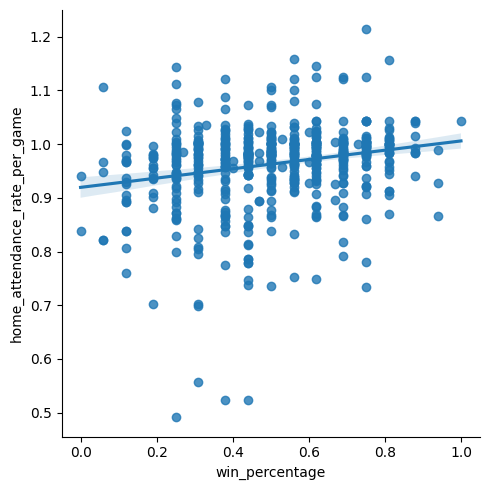

In [126]:
# build a regression between home_attendance_rate_per_game and winning percentage

model1 = smf.ols('home_attendance_rate_per_game ~ win_percentage', data=final_dataset).fit()
print(model1.summary())

# plot the regression line
sns.lmplot(x='win_percentage', y='home_attendance_rate_per_game', data=final_dataset)

In [133]:
# check the correlation between the county gdp and the home attendance rate
final_dataset_without_la = final_dataset[(final_dataset['team_name'] != 'Rams') & (final_dataset['team_name'] != 'Chargers')]
final_dataset_without_la[['gdp_chained_million_dollar', 'home_attendance_rate_per_game']].corr()

,gdp_chained_million_dollar,home_attendance_rate_per_game
gdp_chained_million_dollar,1.000000,0.119955
home_attendance_rate_per_game,0.119955,1.000000


I exclude the Rams and the Chargers because those two teams have moved from another county to Los Angeles during the time period, which made the gdp values rose a lot. <br>
The correlation between the county's gdp and home attendance is very weak.

                                  OLS Regression Results                                 
Dep. Variable:     home_attendance_rate_per_game   R-squared:                       0.014
Model:                                       OLS   Adj. R-squared:                  0.013
Method:                            Least Squares   F-statistic:                     7.825
Date:                           Thu, 14 Mar 2024   Prob (F-statistic):            0.00534
Time:                                   16:54:46   Log-Likelihood:                 633.11
No. Observations:                            538   AIC:                            -1262.
Df Residuals:                                536   BIC:                            -1254.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

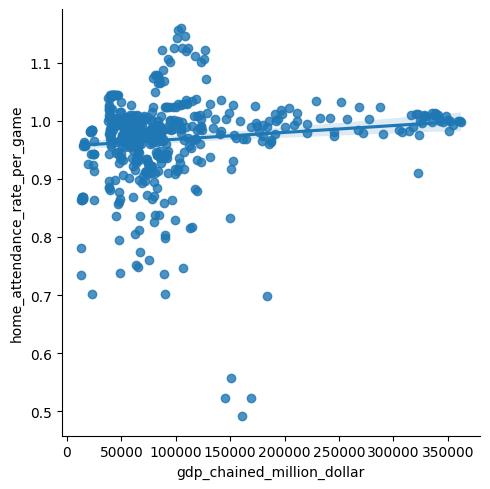

In [134]:
# build a regression between home_attendance_rate_per_game and gdp_chained_million_dollar
model2 = smf.ols('home_attendance_rate_per_game ~ gdp_chained_million_dollar', data=final_dataset_without_la).fit()
print(model2.summary())

# plot the regression line
sns.lmplot(x='gdp_chained_million_dollar', y='home_attendance_rate_per_game', data=final_dataset_without_la)


In [137]:
anova1 = sm.stats.anova_lm(model1, typ=2)
print(anova1)

                  sum_sq     df          F        PR(>F)
win_percentage  0.164807    1.0  28.864242  1.120867e-07
Residual        3.351602  587.0        NaN           NaN


In [138]:
anova2 = sm.stats.anova_lm(model2, typ=2)
print(anova2)

                              sum_sq     df         F    PR(>F)
gdp_chained_million_dollar  0.043701    1.0  7.825196  0.005337
Residual                    2.993381  536.0       NaN       NaN


In [139]:
model3 = smf.ols('home_attendance_rate_per_game ~ renovated', data=final_dataset).fit()
anova3 = sm.stats.anova_lm(model3, typ=2)
print(anova3)

             sum_sq     df         F    PR(>F)
renovated  0.011719    1.0  1.962898  0.161732
Residual   3.504689  587.0       NaN       NaN


In [136]:
table1 = final_dataset.groupby('team_name').agg({'home_attendance_rate_per_game': 'mean', 'win_percentage': 'mean', 'gdp_chained_million_dollar': 'mean'}).sort_values(by='home_attendance_rate_per_game', ascending=False)
table1

,home_attendance_rate_per_game,win_percentage,gdp_chained_million_dollar
team_name,,,
Cowboys,1.052335,0.537222,87700.461667
Dolphins,1.045532,0.462778,123520.055556
Patriots,1.032615,0.764444,43893.905556
Browns,1.022157,0.313889,83051.341111
Eagles,1.018652,0.591667,90925.320556
Bears,0.998759,0.500000,336141.555556
Broncos,0.998748,0.568333,57297.783889
Ravens,0.995083,0.567778,43165.694444
49ers,0.991422,0.450000,185018.000000


## Graphical Analysis

Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.

Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.

Interpret the graphical representations to uncover patterns, trends, and outliers.


### Steps
- draw regression plots between between winning_percentage and home_attendance_rate_per_game, gdp_chained_million$ and home_attendance_rate per game.
- draw box plots for the home_attendance_rate_per_gamer in two groups, the renovated year and the year before.

<Axes: xlabel='renovated', ylabel='home_attendance_rate_per_game'>

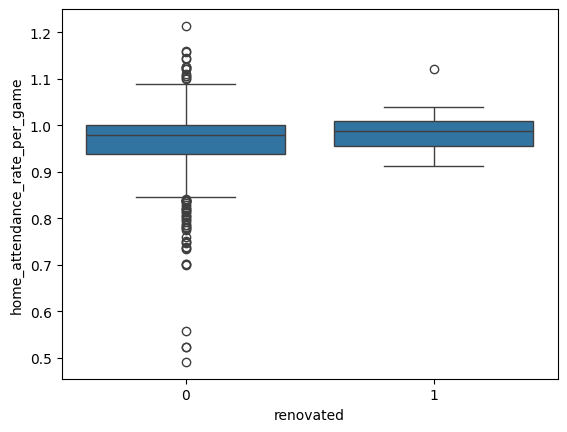

In [145]:
renovatd_table = final_dataset.groupby('renovated').agg({'home_attendance_rate_per_game': 'mean'})
# plot the average home attendance rate for renovated and non-renovated stadiums
sns.boxplot(x='renovated', y='home_attendance_rate_per_game', data=final_dataset)

## Comparative Analysis

Compare and contrast different subsets of your data. This can include comparisons over time, across different categories, or any other relevant segmentation.  Note that for some projects, the nature of this comparative analysis will be obvious.  For others, you will need to think about how you might subset your data.

Discuss any notable similarities or differences you have identified.


### Steps
- group by team, analyze each team's attendance, winning_percentage and gdp over years (line plot?). And find out whether there is similar trend.
- group by year, look at the distribution of team's attendance, winning_percentage and gdp each year.

## Multivariate Analysis

Perform multivariate analysis to understand the relationships among three or more variables in your dataset.

Use techniques like cross-tabulation, pivot tables, and multivariate graphs.


### Steps
- variables to analyze: home_attendance_rate_per_game, winning_percentage, gdp_chained_million$, renovated
- analysis: multiple regression, pivot tables, multivariate graphs.

## Synthesis

Synthesize the findings from your descriptive and inferential statistics along with your graphical analyses to answer your research questions.

Discuss how the combination of the datasets has provided added value in terms of insights or capabilities that would not be possible with the individual datasets in isolation.


## Documentation

Outline the steps you took in your analysis, providing the rationale for the choice of tools and techniques.

Clearly document your code, analyses, and interpretations so that they are understandable and reproducible.


## Reporting & Interpretation

Prepare markdown blocks that summarize your methodology, analysis, and findings.  You should intersperse these with your code.

Your notebook should be well-structured, with clear sections, headings, and subheadings.


## Reflection

Include a section (using one or more markdown blocks) at the end of your notebook in which you reflect on the process of analyzing the data. Discuss any challenges you encountered and how you overcame them.

Critically evaluate the limitations of your analysis and suggest areas for further research or improvement.
